#**Import Libraries**

In [1]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt 

# **The environment**

> in the beginning, we create an "Environment" to represent the windy grid env and to establish where the agent can go and how much rewards it will obtain.

> In this part I will define a Boolean variable to specify if I will use King moves or not

In [2]:
class env(object):
  def __init__(self, kingBool):  # if kingBool is true, the agent can use King's moves, else it can only move N, S, W, E
    self.gridthWidth = 10
    self.gridHeight = 7
    self.startPos = (0, 3)  # (column, row)
    self.currentPos = self.startPos  # init the current position
    self.goalPos = (7, 3)
    self.windVals = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    self.king = kingBool

> I will build `movePosition` method this method for moving the agent to a new position based on the chosen action, and return the new position and the reward

> Reward is `-1` for all states and equal `1` if reach a goal state

In [3]:
class env(env):
  def movePosition(self, action):
    newPos = np.add(list(self.currentPos), list(action))

    # if the agent is using King's Moves, the wind is stochastic
    if (self.king):
      windProbability = np.random.randint(1, 3)
    else:
      windProbability = 1
    # Adjust the agent's position up and down according to the wind
    newPos[1] = newPos[1] + self.windVals[list(self.currentPos)[0]]

    # The wind blew the agent a cell down
    if (windProbability == 2):
      newPos[1] = newPos[1] - 1
    # The wind blew the agent two cells up
    elif (windProbability == 3):
      newPos[1] = newPos[1] + 1  

    # if the agent goes outside the grid env, then make the new position be just inside where it would have gone off
    if (newPos[1] < 0):
      newPos[1] = 0
    elif (newPos[1] >= self.gridHeight):
      newPos[1] = self.gridHeight - 1
    if (newPos[1] == list(self.goalPos)[1] and newPos[0] == list(self.goalPos)[0]):
      reward = 1;
    else:
      reward = -1

    return [(newPos[0], newPos[1]), reward]

> I will build a method for all allowed actions if I use king moves or not

In [4]:
class env(env):
  # not allowing agent to move out off the grid, unless because of wind
  def allowedActionsFromPos(self, position):
    allowedMoves = []
    if (position[0] != 0):
        allowedMoves.append((-1, 0))
    if (position[0] != self.gridthWidth - 1):
        allowedMoves.append((1, 0))
    if (position[1] != self.gridHeight - 1):
        allowedMoves.append((0, 1))
    if (position[1] != 0):
        allowedMoves.append((0, -1))

    # diagonal actions
    if (self.king):
        allowedMoves.append((1, 1))
        allowedMoves.append((-1, -1))
        allowedMoves.append((1, -1))
        allowedMoves.append((-1, 1))
        
        # bottom left(0, 0)
        if (position == (0, 0)):
            if ((-1, 0) in allowedMoves):
                allowedMoves.remove((-1, 0))
            if ((0, -1) in allowedMoves):
                allowedMoves.remove((0, -1))
            allowedMoves.remove((-1, -1))
            allowedMoves.remove((-1, 1))
            allowedMoves.remove((1, -1))

        # top left
        elif (position == (0, self.gridHeight - 1)):
            if ((0, 1) in allowedMoves):
                allowedMoves.remove((0, 1))
            if ((-1, 0) in allowedMoves):
                allowedMoves.remove((-1, 0))
            allowedMoves.remove((1, 1))
            allowedMoves.remove((-1, 1))
            allowedMoves.remove((-1, -1))

        # bottom right
        elif (position == (self.gridthWidth - 1, 0)):
            if ((1, 0) in allowedMoves):
                allowedMoves.remove((1, 0))
            if ((0, -1) in allowedMoves):
                allowedMoves.remove((0, -1))
            allowedMoves.remove((1, 1))
            allowedMoves.remove((1, -1))
            allowedMoves.remove((-1, -1))

        # top right
        elif (position == (self.gridthWidth - 1, self.gridHeight - 1)):
            if ((0, 1) in allowedMoves):
                allowedMoves.remove((0, 1))
            if ((1, 0) in allowedMoves):
                allowedMoves.remove((1, 0))
            allowedMoves.remove((1, 1))
            allowedMoves.remove((1, -1))
            allowedMoves.remove((-1, 1))

        else:
            if (position[0] == self.gridthWidth - 1):
                if ((1, 0) in allowedMoves):
                    allowedMoves.remove((1, 0))
                allowedMoves.remove((1, 1))
                allowedMoves.remove((1, -1))

            if (position[0] == 0):
                if ((-1, 0) in allowedMoves):
                    allowedMoves.remove((-1, 0))
                allowedMoves.remove((-1, 1))
                allowedMoves.remove((-1, -1))

            if (position[1] == self.gridHeight):
                if ((0, 1) in allowedMoves):
                    allowedMoves.remove((0, 1))
                allowedMoves.remove((1, 1))
                allowedMoves.remove((-1, 1))

            if (position[1] == 0):
                if ((0, -1) in allowedMoves):
                    allowedMoves.remove((0, -1))
                allowedMoves.remove((1, -1))
                allowedMoves.remove((-1, -1))

    return allowedMoves

# **Agent**

> I will build a class named `Agent`, The main parts are `Sarsa` implementation and `Q-Learning`, besides, the creation of `Q-Table` and `ϵ−greedy policy` are also included in this class 

In [5]:
class Agent(object):
  def __init__(self, a, e, g, env: env):
    self.alpha = a  # learning rate
    self.epsilon = e  # the probability you want to explore
    self.env = env    # if i use king moves or not
    self.gamma = g    #dicount factor
    self.Q_values = self.createQTables()  # QTable
    self.numOfSteps = 0

> I will build a method for create a QTable.

> QTable is a two dimension dictionary  {'position1':{'action1': value1, 'action2': value2}, 'position2':{'action1': value1, 'action2': value2}, ...}

In [6]:
class Agent(Agent):
  def createQTables(self):
    # dictionary where each key is a state that holds a different number of possible actions, each which has a q-value
    QTable = {}
    for x in range(self.env.gridthWidth):
      for y in range(self.env.gridHeight):
        position = (x, y)
        QTable[position] = {}  # all the posible actions in the current state
        allowedActions = self.env.allowedActionsFromPos(position)
        for action in allowedActions:
          QTable[position][action] = 0
    return QTable


> I will build a method for return the best action

In [7]:
class Agent(Agent):
  def getBestAction(self, position):
    maxVal = np.NINF
    maxAction = None
    for action, value in self.Q_values[position].items():
      if value > maxVal:
        maxVal = value
        bestAction = action
    return bestAction

> I will bult a chooseAction function to select the actions based on the position of the agent

In [8]:
class Agent(Agent):
  def chooseAction(self, position):
    # get all allowed actions in the state
    allowedActions = list(self.Q_values[position].keys())
    # initialize it, and update in loop later
    possibleNextState = self.env.startPos 
    # initializing the return
    action = None
    # Random sample values subject to uniform distribution of "0~1". The value range of the random sample is [0,1), excluding 1.
    randomNum = np.random.rand()
    # this is epsilon-greedy policy
    if (randomNum < self.epsilon):
      subOptimalActionChoiceIndex = np.random.randint(0, len(allowedActions) - 1)  # chooes a random action
      action = allowedActions[subOptimalActionChoiceIndex]
    else:
      action = self.getBestAction(position)
      
    possibleNextState = np.add(list(position), list(action))
    temp = possibleNextState[1] - self.env.windVals[list(possibleNextState)[0]]

    if (temp >= 0):
      possibleNextState[1] = temp

    possibleNextState = (possibleNextState[0], possibleNextState[1])
    return action

> ## Sarsa Algorithm

> ![](https://miro.medium.com/max/1400/1*7WZZgbJQr5lh86LRB2pbVg.png)

In [9]:
class Agent(Agent):
  #Sarsa Method
  def Sarsa(self):
    self.env.currentPos = self.env.startPos
    visited = []  # initialize for visited state
    actionsTaken = []
    visited.append(self.env.startPos)
    chosenAction = self.chooseAction(self.env.currentPos)
    newPosAndReward = None  # initialize
    converged = True
    #to calculate the total reward for each episod
    total_reward = 0

    # loop for each step of the episode
    while True:
      # take action A, observe R and S'
      newPosAndReward = self.env.movePosition(chosenAction)  # [(column, row), reward]
      newPosition = newPosAndReward[0]
      reward = newPosAndReward[1]
      visited.append(newPosition)
      actionsTaken.append(chosenAction)
      self.numOfSteps = self.numOfSteps + 1

      # choose A' from S' using epsilon-greedy policy
      nextAction = self.chooseAction(newPosition)

      # update Q-value of the current position
      #Q(S,A) = Q(S,A) + alpha[R + gama*Q(S',A') - Q(S,A)]
      oldQ = self.Q_values[self.env.currentPos][chosenAction]
      self.Q_values[self.env.currentPos][chosenAction] += self.alpha * (reward + self.gamma * self.Q_values[newPosition][nextAction] - self.Q_values[self.env.currentPos][chosenAction])

      if (abs(oldQ - self.Q_values[self.env.currentPos][chosenAction]) > self.epsilon):
          converged = False

      # advanced to the next state and action
      self.env.currentPos = newPosition
      chosenAction = nextAction

      # next position is the goal
      if (self.env.currentPos == self.env.goalPos):
          break

      total_reward += reward

    return converged, visited, actionsTaken, total_reward


> ## QLearning Algorithm

> ![](https://miro.medium.com/max/1400/1*7AWfjw8YDfoRqnIO71DjiA.png)

In [10]:
class Agent(Agent):
  #QLearning Method
  def QLearning(self):
    self.env.currentPos = self.env.startPos
    visited = []  # initialize for visited state
    actionsTaken = []
    visited.append(self.env.startPos)
    newPosAndReward = None  # initialize
    converged = True
    #to calculate the total reward for each episod
    total_reward = 0

    while True:
      # choose A from S using the epsilon-greedy policy
      chosenAction = self.chooseAction(self.env.currentPos)
      # take A and observe R and S'
      newPosAndReward = self.env.movePosition(chosenAction)
      newPosition = newPosAndReward[0]
      reward = newPosAndReward[1]
      visited.append(newPosition)
      actionsTaken.append(chosenAction)
      self.numOfSteps = self.numOfSteps + 1
      # find the best action from S'
      bestAction = self.getBestAction(newPosition)

      #Q(S,A) = Q(S,A) + alpha[R + gama*max(Q(S',a)) - Q(S,A)]
      oldQ = self.Q_values[self.env.currentPos][chosenAction]
      self.Q_values[self.env.currentPos][chosenAction] += self.alpha * (reward + self.gamma * self.Q_values[newPosition][bestAction] - self.Q_values[self.env.currentPos][chosenAction])

      if (abs(oldQ - self.Q_values[self.env.currentPos][chosenAction]) > self.epsilon):
          converged = False

      # advance to the next state
      self.env.currentPos = newPosition

      if (self.env.currentPos == self.env.goalPos):
          break

      total_reward += reward

    return converged, visited, actionsTaken, total_reward

# **SARSA & QLearning**

## Optimal Policy plot

> ### <font color='green'>**`X` Start State**</font> 
> ### <font color='black'>**`X` Goal State**</font>


In [11]:
def optimal_policy(arr=[(0,0)]):
  #check if I Converge or not
  if len(arr) != 0:
    #split the number of columns and rows
    col, row = zip(*arr)
    col = [x +0.5 for x in col]
    row = [x +0.5 for x in row]

    fig = plt.figure(figsize=(12,7), facecolor='#CCE5FF')
    ax = fig.add_subplot(1, 1, 1)
    #plot the optimal path from the start to the goal
    ax.plot(col, row, 'b', linewidth=3, markersize=8)
    ax.plot(col, row,'o', markersize=8 ,color = 'orange')
    
    # Initialize the start state
    ax.plot(.5, 3.5,'gX', linewidth=2, markersize=24)
    # Initialize the final state
    ax.plot(7.5, 3.5,'kX', linewidth=2, markersize=24)
    


    #build the Gridworld diagrame
    major_ticks = np.arange(0, 11, 1)
    minor_ticks = np.arange(0, 8, 1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(major_ticks, minor=True)
    ax.set_yticks(minor_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    ax.grid(which='both')
    plt.gca().patch.set_facecolor('#CCFFFF')
    plt.suptitle("OPTIMAL POLICY", fontsize=14, fontweight='bold')
    plt.xlabel("COLUMNS", fontsize=14, fontweight='bold')
    plt.ylabel("ROWS", fontsize=14, fontweight='bold')
    plt.show()
  else:
    print('Not Converge')

## SARSA Play_Train method

> SARSA(Alpha, Epsilon, Gamma, boolean(If problem king's moves or not), number of episods

In [12]:
def play_train_Sarsa(a, e, g, bol, epi):
  testenv = env(bol) #Initialize object from env. class
  testAgent = Agent(a, e, g, testenv) #Initialize object from agent class
  timeSteps = [0] # Initialize array for calculate time
  episodes = [0]  # Initialize array for episodes time
  convergedX = []
  convergedY = []
  alreadyConverged = False
  for x in range(epi):  # the max number of episodes
      result = testAgent.Sarsa()
      timeSteps.append(testAgent.numOfSteps)
      episodes.append(x)
      if (result[0] and not alreadyConverged):
          print("the optimal policy. The path is ...")
          print(result[1])
          print('==========================================================\n')
          optimal_policy(result[1])
          print('==========================================================\n')
          print("The actions taken on that path are ...")
          print(result[2])
          print('==========================================================\n')
          print("The Total Reward")
          print(result[3])
          print('==========================================================\n')
          convergedX.append(x)
          convergedY.append((testAgent.numOfSteps))
          alreadyConverged = True

  print("The Total Time to converge")
  print(convergedY)
  print('==========================================================\n')
  print("The Total number of episod to converge")
  print(convergedX)
  print('==========================================================\n')
  plt.figure(figsize=(10,5), facecolor='#CCE5FF')
  plt.gca().patch.set_facecolor('#CCFFFF')
  plt.plot(timeSteps, episodes, 'r-', convergedY, convergedX, 'bo' , linewidth=3, markersize=8)
  plt.suptitle("Sarsa", fontsize=14, fontweight='bold')
  plt.xlabel("Total Timesteps", fontsize=14, fontweight='bold')
  plt.ylabel("Episodes", fontsize=14, fontweight='bold')
  plt.grid()
  plt.show()

## QLearning Play_Train method

> QLearning(Alpha, Epsilon, Gamma, boolean(If problem king's moves or not), number of episods

In [13]:
def play_train_QL(a, e, g, bol, epi):
  testenv = env(bol)  #Initialize object from env. class
  testAgent = Agent(a, e, g, testenv) #Initialize object from agent class
  timeSteps = [0] # Initialize array for calculate time
  episodes = [0]  # Initialize array for episodes time
  convergedX = []
  convergedY = []
  alreadyConverged = False
  for x in range(epi):  # the max number of episodes
      result = testAgent.QLearning()
      timeSteps.append(testAgent.numOfSteps)
      episodes.append(x)
      if (result[0] and not alreadyConverged):
          print("the optimal policy. The path is ...")
          print(result[1])
          print('==========================================================\n')
          optimal_policy(result[1])
          print('==========================================================\n')
          print("The actions taken on that path are ...")
          print(result[2])
          print('==========================================================\n')
          print("The Total Reward")
          print(result[3])
          print('==========================================================\n')
          convergedX.append(x)
          convergedY.append((testAgent.numOfSteps))
          alreadyConverged = True

  print("The Total Time to converge")
  print(convergedY)
  print('==========================================================\n')
  print("The Total number of episod to converge")
  print(convergedX)
  print('==========================================================\n')
  plt.figure(figsize=(10,5), facecolor='#CCE5FF')
  plt.gca().patch.set_facecolor('#CCFFFF')
  plt.plot(timeSteps, episodes, 'r-', convergedY, convergedX, 'bo', linewidth=3, markersize=8)
  plt.suptitle("QLearning", fontsize=14, fontweight='bold')
  plt.xlabel("Total Timesteps", fontsize=14, fontweight='bold')
  plt.ylabel("Episodes", fontsize=14, fontweight='bold')
  plt.grid()
  plt.show()

## 1. SARSA
> I will execute SARSA algorithm with different combinations of ∈ and α to see which combinations is good

* α=0.5,∈=0.1,gama = 0.9
* α=0.1,∈=0.2,gama = 0.9
* α=0.2,∈=0.05,gama = 0.9
* α=0.9,∈=0.001,gama = 0.9

###1.1 SARSA
> α=0.5,∈=0.1,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (1, 3), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (7, 3)]



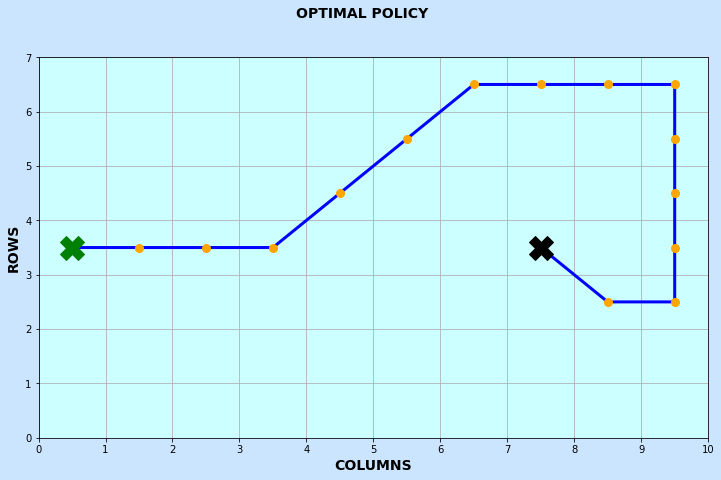


The actions taken on that path are ...
[(1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1), (0, -1), (0, -1), (-1, 0), (-1, 0)]

The Total Reward
-14

The Total Time to converge
[9343]

The Total number of episod to converge
[293]



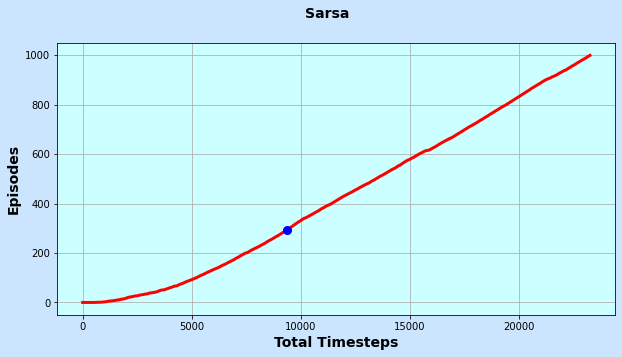

In [27]:
#SARSA
play_train_Sarsa(0.5, 0.1, 0.9, False, 1000)

> As we can see the agent is converge
* after `293` episods 
* with total time steps `9343`
* and total reward = `-14`

> As we can see this result is good because the path is the optimal path

###1.2 SARSA 
> α=0.1,∈=0.2,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (0, 2), (0, 1), (0, 0), (0, 1), (1, 1), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (1, 0), (0, 0), (1, 0), (2, 0), (3, 0), (2, 1), (2, 0), (1, 0), (2, 0), (2, 1), (3, 1), (2, 2), (2, 3), (3, 3), (3, 3), (3, 3), (4, 4), (5, 5), (5, 5), (5, 5), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 4), (8, 4), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (7, 3)]



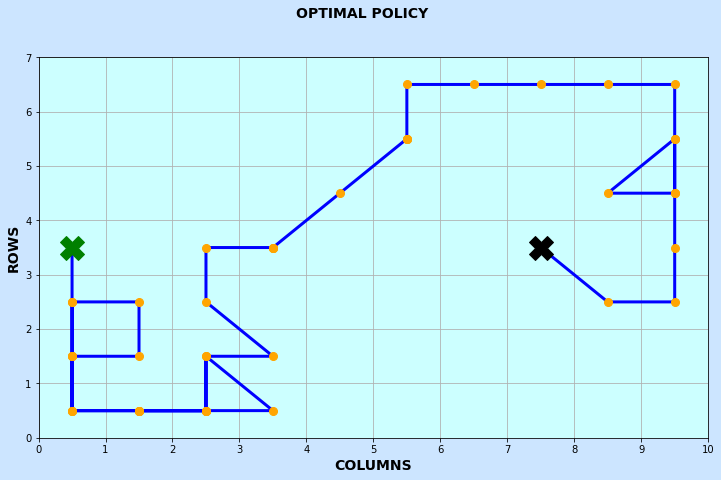


The actions taken on that path are ...
[(0, -1), (0, -1), (0, -1), (0, 1), (1, 0), (0, 1), (-1, 0), (0, -1), (0, -1), (1, 0), (1, 0), (-1, 0), (-1, 0), (1, 0), (1, 0), (1, 0), (-1, 0), (0, -1), (-1, 0), (1, 0), (0, 1), (1, 0), (-1, 0), (0, 1), (1, 0), (0, -1), (0, -1), (1, 0), (1, 0), (0, -1), (0, -1), (0, 1), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1), (-1, 0), (1, 0), (0, -1), (0, -1), (0, -1), (-1, 0), (-1, 0)]

The Total Reward
-44

The Total Time to converge
[10414]

The Total number of episod to converge
[92]



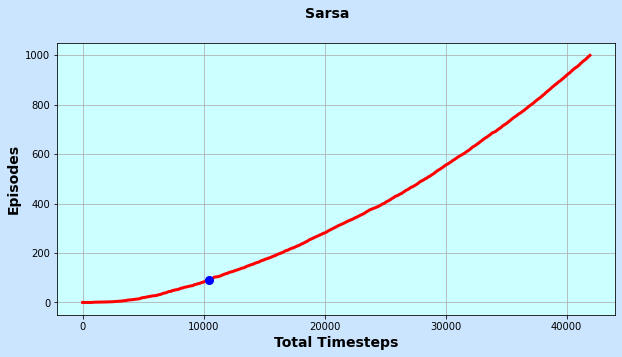

In [15]:
#SARSA
play_train_Sarsa(0.1, 0.2, 0.9, False, 1000)

> As we can see the agent is converge 
* after `92` episods, It is much better than `1.1 SARSA`
* with total time steps `10414`, It's not better than `1.1 SARSA`
* and total reward = `-44`, It's not better than `1.1 SARSA`

> As we can see this result is not good and not bad because the path is not the optimal path but in the end the agent reach the goal state

###1.3 SARSA 
> α=0.2,∈=0.05,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 5), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (7, 3)]



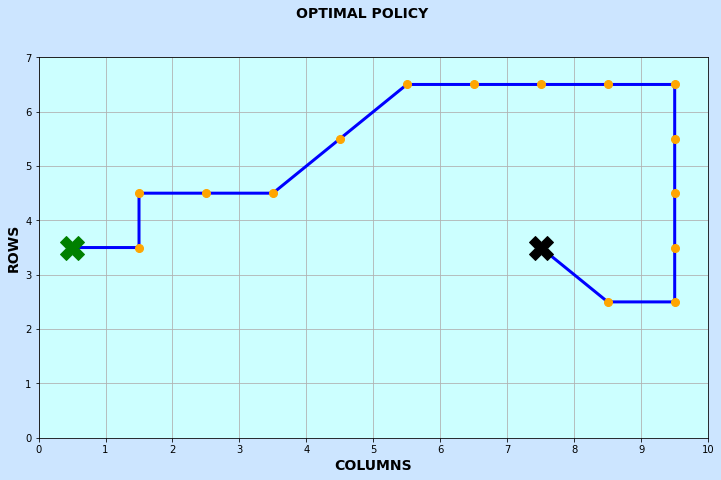


The actions taken on that path are ...
[(1, 0), (0, 1), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1), (0, -1), (0, -1), (-1, 0), (-1, 0)]

The Total Reward
-15

The Total Time to converge
[11954]

The Total number of episod to converge
[278]



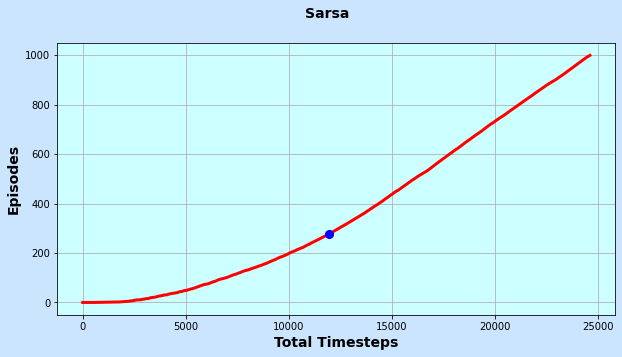

In [16]:
#SARSA
play_train_Sarsa(0.2, 0.05, 0.9, False, 1000)

> As we can see the agent is converge 
* after `278` episods, It's better than `1.1 SARSA` and worse than `1.2 SARSA`
* with total time steps `11954`,It's worst than `1.1 SARSA` and `1.2 SARSA`
* and total reward = `-15`, It is much better than `1.2 SARSA` but not better tan  `1.1 SARSA`

> As we can see this result is good because the path is not the optimal path but it's so close to the optimal path and in the end the agent reach the goal state

###1.4 SARSA 
> α=0.9,∈=0.001,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (1, 3), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (7, 3)]



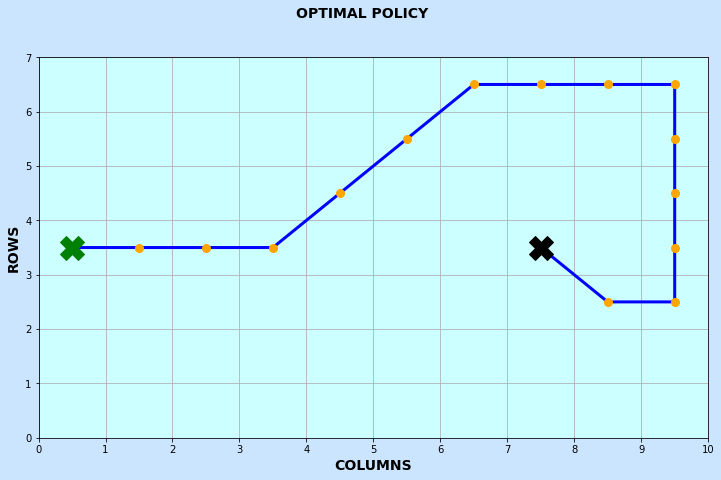


The actions taken on that path are ...
[(1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1), (0, -1), (0, -1), (-1, 0), (-1, 0)]

The Total Reward
-14

The Total Time to converge
[2826]

The Total number of episod to converge
[63]



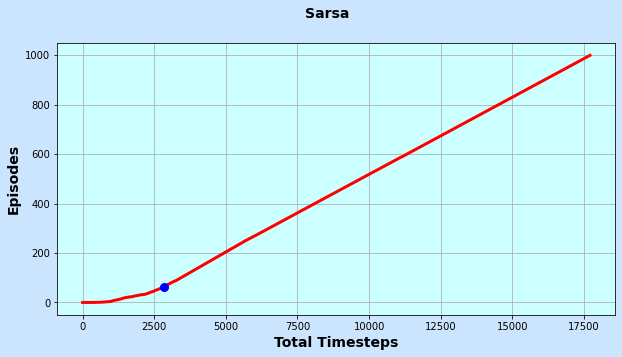

In [17]:
#SARSA
play_train_Sarsa(0.9, 0.001, 0.9, False, 1000)

> As we can see the agent is converge 
* after `63` episods, It is much better than `1.1 SARSA` , `1.2 SARSA` and `1.3 SARSA`
* with total time steps `2826`,It is much better than`1.1 SARSA` , `1.2 SARSA` and `1.3 SARSA`
* and total reward = `-14`, It is much better than `1.2 SARSA` and `1.3 SARSA` and look like `1.1 SARSA`

>As we can see, this result is good because the path is the optimal path.

> As we can see, this trial is the best trial.

### 1. SARSA Conclusion

> the best model is the last one `1.4 SARSA`
* episodes = `63`
* total time steps = `2826`
* Reward = `-14`

## 2. QLearning
> I will execute QLearning algorithm with different combinations of ∈ and α to see which combinations is better

* α=0.5,∈=0.1,gama = 0.9
* α=0.1,∈=0.2,gama = 0.9
* α=0.2,∈=0.05,gama = 0.9
* α=0.9,∈=0.001,gama = 0.9

###2.1 QLearning
> α=0.5,∈=0.1,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (1, 3), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (7, 3)]



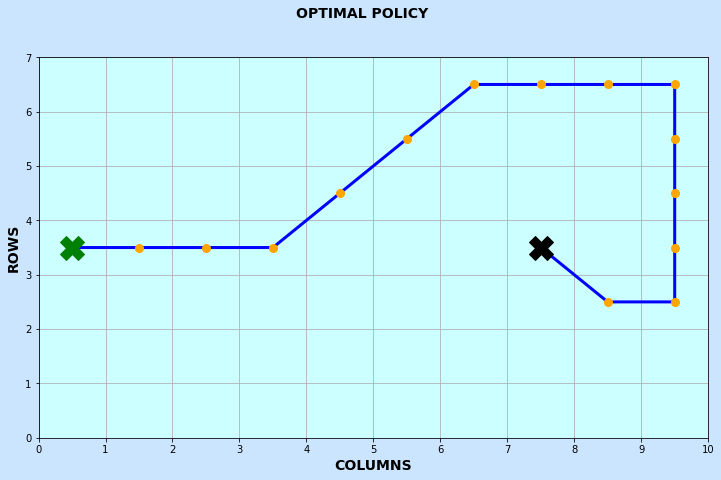


The actions taken on that path are ...
[(1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1), (0, -1), (0, -1), (-1, 0), (-1, 0)]

The Total Reward
-14

The Total Time to converge
[5025]

The Total number of episod to converge
[111]



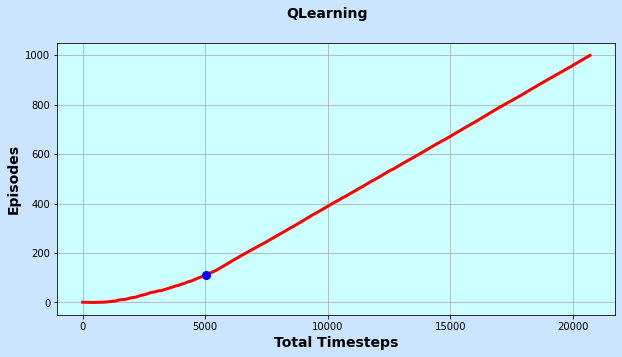

In [18]:
#QL
play_train_QL(0.5, 0.1, 0.9, False, 1000)

> As we can see the agent is converge 
* after `111` episods 
* with total time steps `5025`
* and total reward = `-14`

>As we can see, this result is good because the path is the optimal path.

###2.2 QLearning 
> α=0.1,∈=0.2,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (2, 4), (2, 3), (3, 3), (3, 3), (4, 4), (4, 4), (4, 4), (5, 5), (5, 5), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (7, 3)]



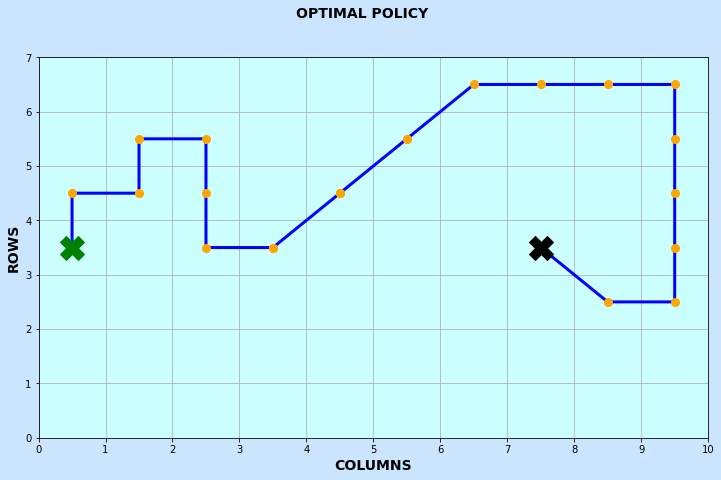


The actions taken on that path are ...
[(0, 1), (1, 0), (0, 1), (1, 0), (0, -1), (0, -1), (1, 0), (0, -1), (1, 0), (0, -1), (0, -1), (1, 0), (0, -1), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1), (0, -1), (0, -1), (-1, 0), (-1, 0)]

The Total Reward
-22

The Total Time to converge
[8824]

The Total number of episod to converge
[65]



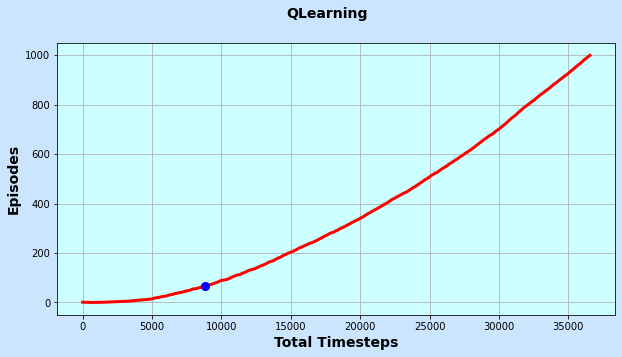

In [19]:
#QL
play_train_QL(0.1, 0.2, 0.9, False, 1000)

> As we can see the agent is converge 
* after `65` episods, It is much better than `2.1 QLearning`
* with total time steps `8824`, It's not better than `2.1 QLearning`
* and total reward = `-22`, It's not better than `2.1 QLearning`

>As we can see this result is not good and not bad because the path is not the optimal path but in the end the agent reach the goal state

###2.3 QLearning
> α=0.2,∈=0.05,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (1, 3), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (7, 3)]



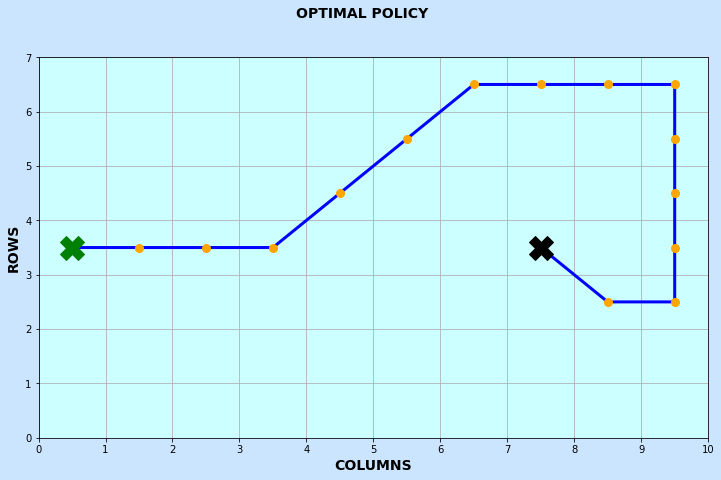


The actions taken on that path are ...
[(1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1), (0, -1), (0, -1), (-1, 0), (-1, 0)]

The Total Reward
-14

The Total Time to converge
[11640]

The Total number of episod to converge
[276]



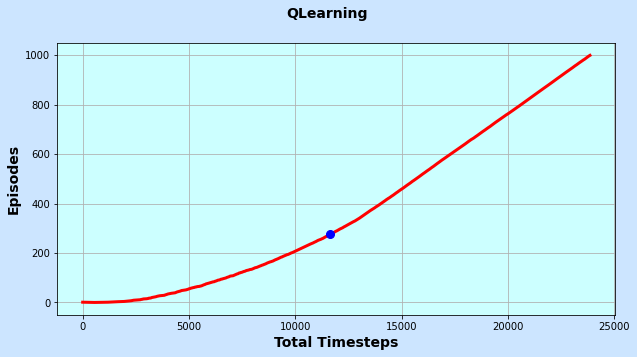

In [20]:
#QL
play_train_QL(0.2, 0.05, 0.9, False, 1000)

> As we can see the agent is converge 
* after `276` episods, It's not better than `2.1 QLearning` and `2.2 QLearning`
* with total time steps `11640`,It'sworse than `2.1 QLearning` and `2.2 QLearning`
* and total reward = `-14`, It is much better than `2.2 QLearning` and look like `2.1 QLearning`

>As we can see, this result is good because the path is the optimal path.

###2.4 QLearning
> α=0.9,∈=0.001,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (1, 3), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (8, 2), (7, 3)]



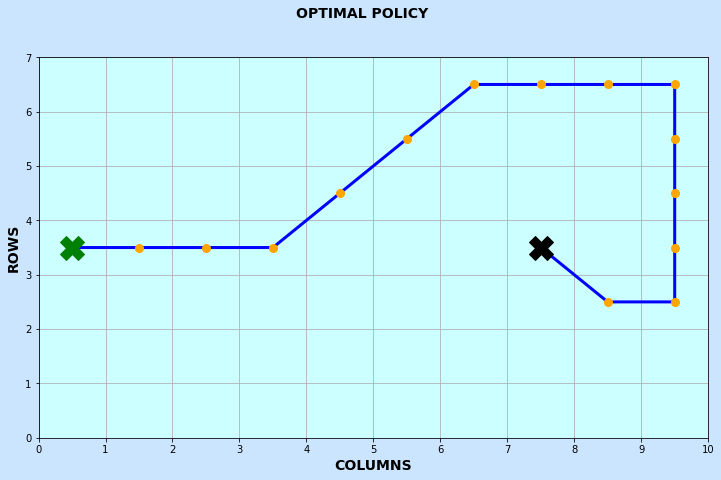


The actions taken on that path are ...
[(1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1), (0, -1), (0, -1), (-1, 0), (-1, 0)]

The Total Reward
-14

The Total Time to converge
[2752]

The Total number of episod to converge
[62]



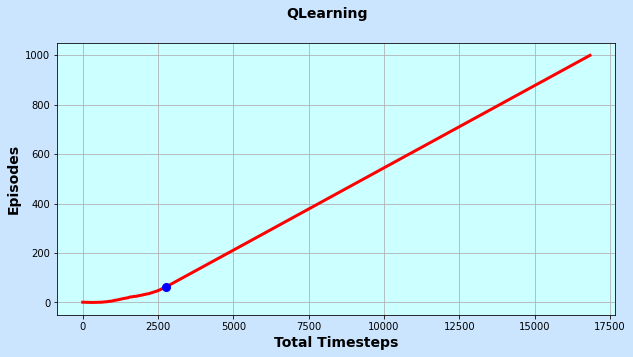

In [21]:
#QL
play_train_QL(0.9, 0.001, 0.9, False, 1000)

> As we can see the agent is converge 
* after `62` episods, It is much better than `2.1 QLearning`, `2.3 QLearning` and `2.2 QLearning`
* with total time steps `2752`,It is much better than`2.1 QLearning` , `2.2 QLearning` and `2.3 QLearning`
* and total reward = `-14`, It is much better than `2.1 QLearning` and look loke `2.2 QLearning` and `2.3 QLearning`

> As we can see, this result is good because the path is the optimal path.

>As we can see, this trial is the best trial.

###QLearning Conclusion

> the best model is the last one `2.4 QLearning`
* episodes = `62`
* total time steps = `2752`
* Reward = `-14`

#**King's Moves**

## 3. SARSA King's Moves
> I will execute SARSA algorithm with king's move with different combinations of ∈ and α to see which combinations is good

> I will select the best ∈ and α from `1.4 SARSA`
*  α = 0.9, ∈ = 0.001, gama = 0.9

> and I will select ∈ and α randomly
*  α = 0.4, ∈ = 0.5, gama = 0.9

###3.1 SARSA King's moves
>  α = 0.9, ∈ = 0.001,gama = 0.9

The Total Time to converge
[]

The Total number of episod to converge
[]



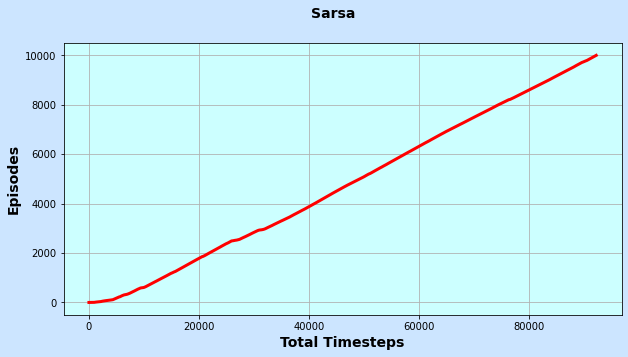

In [22]:
#SARSA King's Move
play_train_Sarsa(0.9, 0.001, 0.9, True, 10000)

> As we can see this trial it's not converge after `10000` episod so I will increase the value of `∈`  to be `0.9` and `α` to be `0.1` to see if will converge or not

the optimal policy. The path is ...
[(0, 3), (1, 4), (1, 2), (1, 3), (2, 2), (1, 2), (1, 3), (2, 4), (1, 2), (2, 0), (3, 0), (4, 0), (5, 2), (6, 3), (5, 5), (5, 6), (6, 6), (6, 6), (7, 6), (6, 6), (5, 6), (5, 5), (4, 4), (3, 5), (3, 6), (2, 6), (3, 6), (3, 5), (3, 6), (2, 6), (1, 6), (0, 5), (0, 6), (0, 4), (1, 5), (1, 6), (0, 5), (0, 4), (0, 4), (0, 4), (1, 4), (0, 4), (1, 3), (1, 3), (1, 3), (0, 3), (1, 3), (0, 2), (0, 1), (1, 1), (0, 1), (1, 2), (0, 2), (1, 1), (2, 1), (1, 1), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 4), (6, 4), (7, 4), (8, 5), (9, 5), (9, 3), (9, 4), (8, 3), (7, 4), (8, 4), (8, 3), (8, 4), (8, 5), (8, 6), (9, 6), (8, 6), (7, 6), (8, 6), (7, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 3), (8, 3), (9, 4), (8, 4), (7, 5), (7, 6), (8, 6), (9, 6), (9, 5), (8, 3), (9, 3), (9, 1), (8, 1), (8, 3), (9, 2), (8, 1), (8, 1), (9, 1), (8, 0), (9, 2), (9, 3), (9, 1), (9, 1), (9, 0), (9, 0), (9, 0), (9, 1), (9, 2), (9, 3), (9, 1), (8,

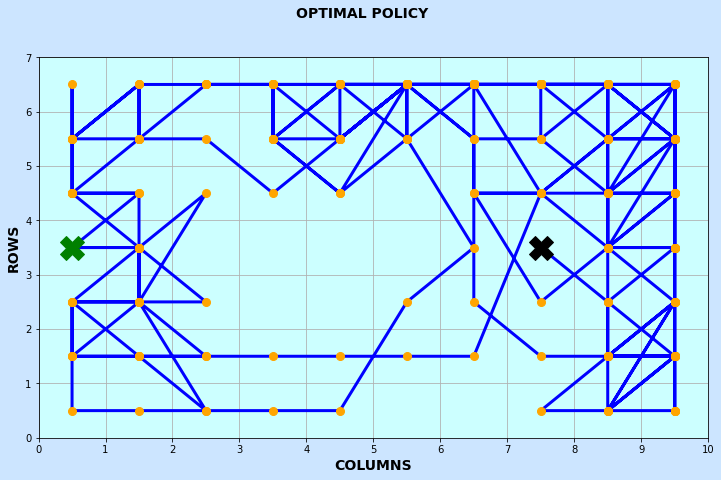


The actions taken on that path are ...
[(1, 1), (0, -1), (0, 1), (1, 0), (-1, 0), (0, 1), (1, 1), (-1, -1), (1, -1), (1, 0), (1, 0), (1, 1), (1, 1), (-1, 0), (0, 1), (1, 1), (0, -1), (1, -1), (-1, -1), (-1, 0), (0, -1), (-1, -1), (-1, 0), (0, 1), (-1, 0), (1, 0), (0, -1), (0, 1), (-1, 0), (-1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (0, 1), (-1, -1), (0, -1), (0, 1), (0, 1), (1, 0), (-1, 0), (1, 0), (0, 1), (0, 1), (-1, 0), (1, 1), (-1, -1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, 0), (1, 0), (1, 1), (-1, 0), (1, 0), (-1, 0), (-1, 0), (0, 1), (0, 1), (1, 0), (1, -1), (1, 0), (1, -1), (1, 0), (1, 0), (1, 1), (-1, -1), (1, -1), (1, 0), (1, -1), (0, -1), (0, 1), (-1, -1), (-1, 0), (1, -1), (0, -1), (0, 1), (0, 1), (0, 1), (1, 1), (-1, 0), (-1, 0), (1, 0), (-1, -1), (0, -1), (1, 0), (1, 0), (0, -1), (0, -1), (-1, 0), (1, 1), (-1, 0), (-1, 0), (0, -1), (1, -1), (1, 0), (0, -1), (-1, -1), (1, 0), (0, -1), (-1, 0), (0, 1), (1, -1), (-1, 0), (0, -1), (1, 0), (-1, -1), (1, 1), (0, 1), (0, -1), (0

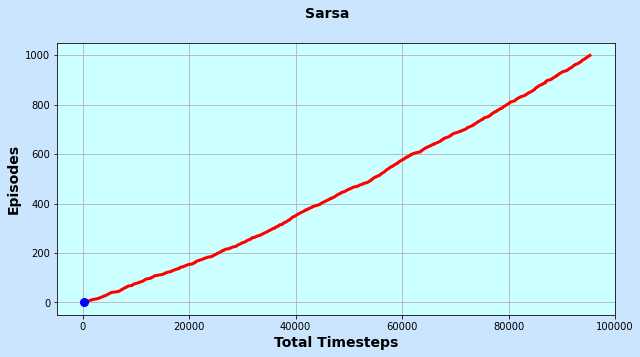

In [23]:
#SARSA King's Move
play_train_Sarsa(0.1, 0.9, 0.9, True, 1000)

> As we can see the agent is converge 
* in the first episod
* with total time steps `288`
* and total reward = `-287`

> As we can see, this trial is converged but take long time in the same episod until converge ,and it's converge with bad way as we can see from the path

###3.2 SARSA King's moves
>  α = 0.4, ∈ = 0.5,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (0, 4), (1, 3), (0, 2), (1, 2), (0, 1), (1, 1), (0, 1), (1, 0), (2, 0), (2, 1), (3, 0), (4, 1), (5, 0), (6, 1), (6, 1), (7, 3)]



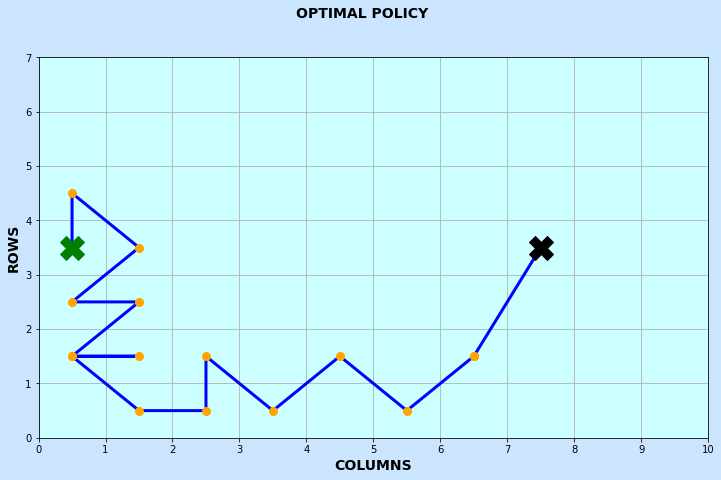


The actions taken on that path are ...
[(0, 1), (1, -1), (-1, 0), (1, 1), (-1, -1), (1, 1), (-1, 0), (1, 0), (1, 1), (0, 1), (1, 0), (1, 0), (1, -1), (1, 1), (0, -1), (1, 0)]

The Total Reward
-15

The Total Time to converge
[4469]

The Total number of episod to converge
[55]



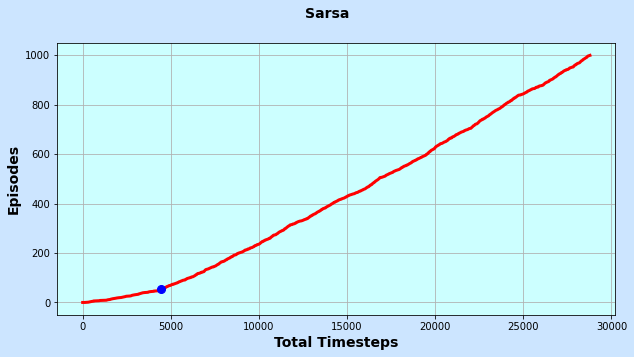

In [24]:
#SARSA King's Move
play_train_Sarsa(0.4, 0.5, 0.9, True, 1000)

> As we can see the agent is converge 
* in the episod number `55`
* with total time steps `4469`
* and total reward = `-15`

> So This trial is better than the previous one in the reward and the optimal path but it's took long time and episodes to converge

### 3. SARSA Kings Moves Conclusion

> the best model is the last one `3.2 SARSA Kings Moves`
* episodes = `55`
* total time steps = `4469`
* Reward = `-15`

## 4. QLearning King's Moves
> I will execute QLearning algorithm with king's move with different combinations of ∈ and α to see which combinations is good

> I will select the same ∈ and α from `SARSA King's Moves`
*  α = 0.1, ∈ = 0.9,gama = 0.9

> and I will select ∈ and α randomly
* α = 0.4, ∈ = 0.5, gama = 0.9

###4.1 QLearning King's moves
>  α = 0.1, ∈ = 0.9,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (0, 3), (0, 1), (0, 2), (1, 2), (2, 2), (1, 1), (0, 0), (1, 0), (2, 0), (2, 0), (1, 0), (0, 0), (1, 0), (1, 0), (2, 0), (3, 0), (2, 1), (2, 0), (1, 0), (0, 0), (1, 0), (2, 1), (3, 2), (4, 2), (5, 4), (5, 3), (6, 2), (6, 2), (7, 2), (6, 2), (7, 4), (7, 6), (7, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 4), (9, 3), (9, 1), (8, 0), (9, 1), (8, 1), (8, 3), (7, 4), (8, 5), (7, 5), (7, 6), (8, 6), (7, 6), (8, 6), (7, 6), (8, 6), (7, 6), (6, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 6), (7, 6), (6, 6), (7, 6), (8, 6), (7, 6), (8, 6), (7, 6), (7, 6), (6, 6), (7, 6), (7, 6), (8, 6), (7, 5), (6, 6), (5, 6), (4, 5), (3, 5), (3, 6), (4, 6), (3, 6), (2, 6), (1, 4), (2, 4), (3, 2), (2, 2), (3, 1), (4, 1), (3, 2), (2, 1), (1, 1), (2, 0), (2, 0), (3, 0), (4, 2), (5, 3), (4, 3), (3, 4), (3, 3), (3, 5), (4, 4), (5, 4), (6, 5), (7, 6), (7, 6), (6, 6), (5, 6), (5, 6), (4, 6), (5, 6), (4, 5), (5, 6), (4, 6), (5, 6), (4, 5), (3, 5), (2, 6), (1, 5), (2, 3), (2, 3), (1,

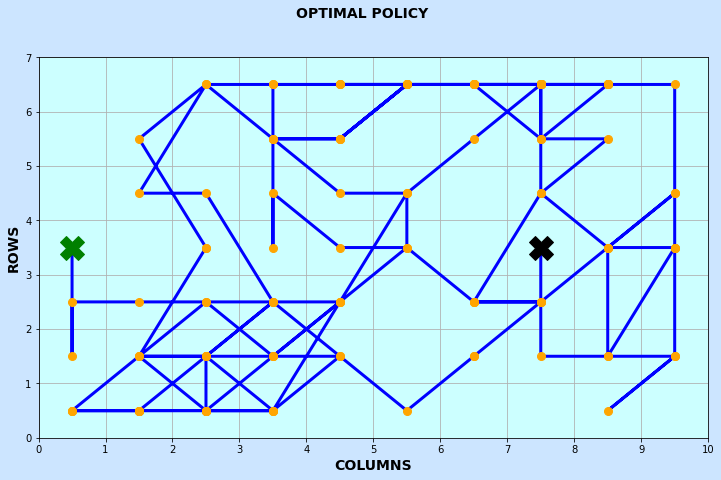


The actions taken on that path are ...
[(0, 1), (0, -1), (0, 1), (1, 0), (1, 1), (-1, -1), (-1, 0), (1, 0), (1, 0), (0, 1), (-1, 0), (-1, 0), (1, 0), (0, 1), (1, 0), (1, 0), (-1, 0), (0, -1), (-1, 0), (-1, 0), (1, 0), (1, 1), (1, 1), (1, 0), (1, 1), (0, -1), (1, -1), (0, -1), (1, -1), (-1, -1), (1, 0), (0, 1), (0, -1), (-1, 0), (1, 1), (1, -1), (1, 1), (0, -1), (0, -1), (0, -1), (-1, -1), (1, 1), (-1, 0), (0, 1), (-1, 0), (1, 0), (-1, -1), (0, 1), (1, -1), (-1, 0), (1, 1), (-1, 0), (1, 0), (-1, -1), (-1, 0), (-1, 0), (1, -1), (1, 1), (1, 0), (0, -1), (-1, 0), (-1, -1), (1, 0), (1, -1), (-1, -1), (1, 1), (-1, 0), (0, -1), (-1, 1), (1, 1), (0, -1), (1, 0), (-1, -1), (-1, 0), (-1, -1), (-1, -1), (-1, 0), (0, 1), (1, 0), (-1, 0), (-1, 0), (-1, -1), (1, 0), (1, -1), (-1, 0), (1, 0), (1, 0), (-1, 0), (-1, -1), (-1, 0), (1, -1), (0, 1), (1, 1), (1, 1), (1, 0), (-1, 0), (-1, 0), (0, -1), (0, 1), (1, -1), (1, -1), (1, 0), (1, 1), (0, -1), (-1, 0), (-1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (

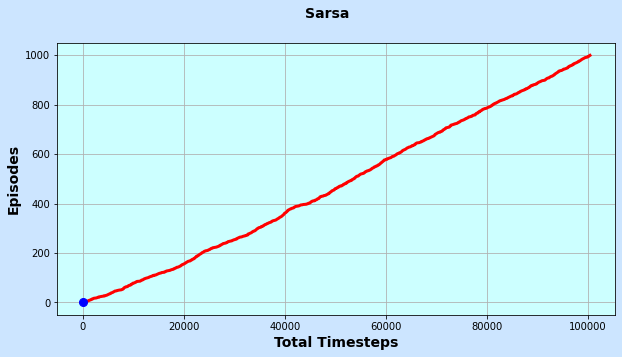

In [25]:
#QL King's Move
play_train_Sarsa(0.1, 0.9, 0.9, True, 1000)

> As we can see the agent is converge 
* in the first episod
* with total time steps `140`
* and total reward = `-139`

###4.2 QLearning King's moves
>  α = 0.4, ∈ = 0.5,gama = 0.9

the optimal policy. The path is ...
[(0, 3), (1, 2), (0, 1), (1, 1), (1, 0), (0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 3), (5, 3), (4, 3), (5, 4), (6, 3), (7, 3)]



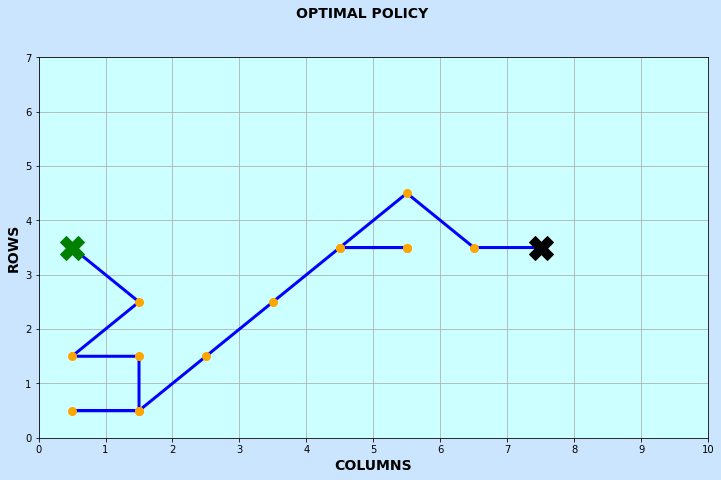


The actions taken on that path are ...
[(1, -1), (-1, 0), (1, 1), (0, -1), (-1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, 0), (1, 1), (1, -1), (1, -1)]

The Total Reward
-14

The Total Time to converge
[3090]

The Total number of episod to converge
[27]



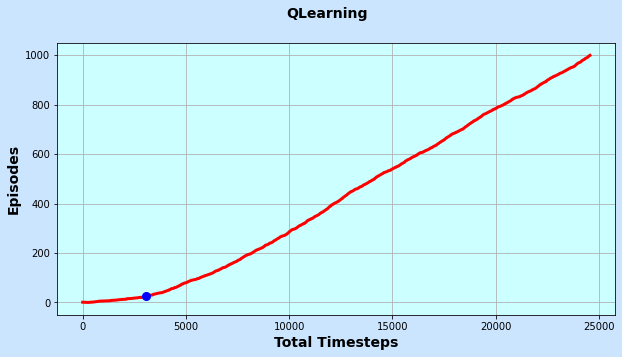

In [26]:
#QL King's Move
play_train_QL(0.4, 0.5, 0.9, True, 1000)

> As we can see the agent is converge 
* in the episod number `27`
* with total time steps `3090`
* and total reward = `-14`

> So This trial is better than the previous one in the reward and the optimal path but it's took long time and episodes to converge

### 4. QLearning King's Moves Conclusion

> the best model is the last one `4.2 QLearning King's Moves`
* episodes = `27`
* total time steps = `3090`
* Reward = `-14`

#Resources

>[Ref](https://programmersought.com/article/27077044249/)
[Ref](http://incompleteideas.net/book/ebook/node64.html)
[Ref](https://blog.csdn.net/WZX_Hello/article/details/115560022)
[Ref](https://github.com/ibrahim-elshar/gym-windy-gridworlds)
[Ref](https://leimao.github.io/blog/RL-On-Policy-VS-Off-Policy/)
[Ref](https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Q-Learning%20Solution.ipynb)
[Ref](https://github.com/ellastewart/CISC453_Assn2)
[Ref](https://github.com/georgeyiasemis/SARSA-and-Q-learning-on-a-Windy-Grid-World)